In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref/exparser')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/exparser/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['author', 'title', 'journal'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0722 00:48:31.737127 11320 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 00:48:33.082754 11320 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 00:49:07.045530 11320 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 00:49:07.329819 11320 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 00:49:07.334671 11320 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 14


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0722 00:51:18.361976 11320 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0722 00:51:18.464844 11320 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1841270 samples, validate on 230159 samples
Epoch 1/10
1841270/1841270 [==============================] - 409s 222us/step - loss: 0.2065 - acc: 0.9705 - val_loss: 0.0501 - val_acc: 0.9899
Epoch 2/10
1841270/1841270 [==============================] - 320s 174us/step - loss: 0.0294 - acc: 0.9906 - val_loss: 0.0169 - val_acc: 0.9949
Epoch 3/10
1841270/1841270 [==============================] - 276s 150us/step - loss: 0.0118 - acc: 0.9968 - val_loss: 0.0093 - val_acc: 0.9975
Epoch 4/10
1841270/1841270 [==============================] - 279s 151us/step - loss: 0.0087 - acc: 0.9976 - val_loss: 0.0085 - val_acc: 0.9976
Epoch 5/10
1841270/1841270 [==============================] - 270s 147us/step - loss: 0.0082 - acc: 0.9977 - val_loss: 0.0082 - val_acc: 0.9976
Epoch 6/10
1841270/1841270 [==============================] - 274s 149us/step - loss: 0.0080 - acc: 0.9978 - val_loss: 0.0081 - val_acc: 0.9977
Epoch 7/10
1841270/1841270 [==============================] - 269s 146us/step - los

# Learning curves

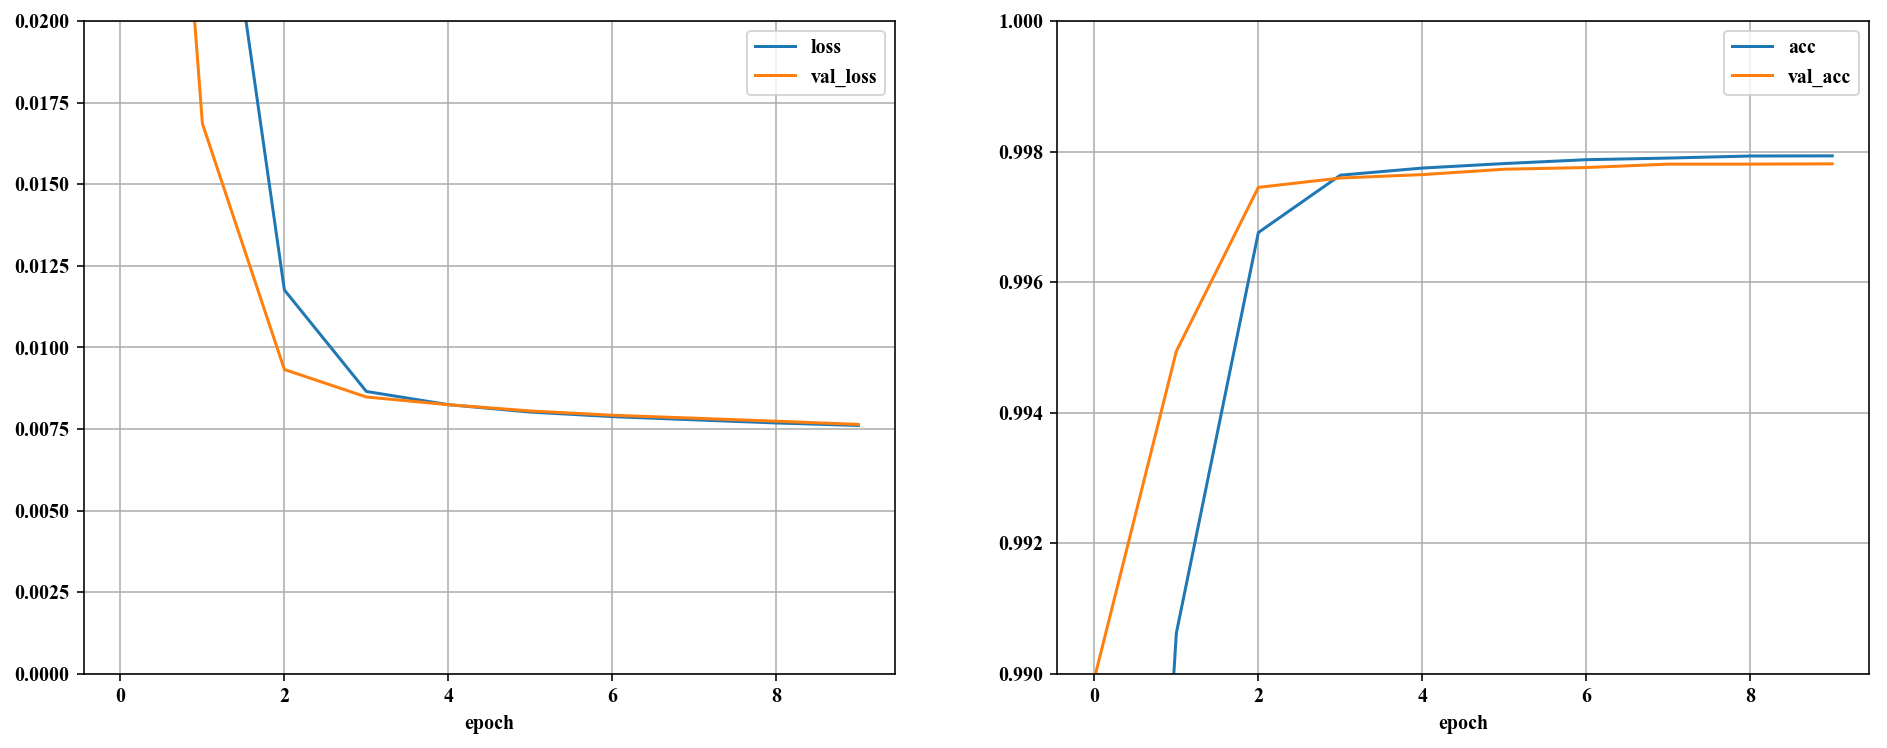

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227840
           1       0.95      0.82      0.88      2319

   micro avg       1.00      1.00      1.00    230159
   macro avg       0.98      0.91      0.94    230159
weighted avg       1.00      1.00      1.00    230159

[[227745     95]
 [   408   1911]]


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['author', 'title', 'journal']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,author,title,journal,year,id2,author,title,journal,year
210094,8723975c-ac03-11e9-a3dc-04ea56df376a,"<unk> Calendar , <unk> Mathematics and Computers",<unk>,<unk>,2001.0,8721280a-ac03-11e9-8ab2-04ea56df376a,<unk>,IMACS Calendar,<unk>,2001.0
142638,94be564c-ac03-11e9-8506-04ea56df376a,<unk>,Daloz <unk> <unk> and Socio-Political <unk>,<unk>,2013.0,94c029c2-ac03-11e9-b593-04ea56df376a,Exploring Socio-Political Aspects,Daloz J.-P,<unk>,2013.0
104245,83a5fa24-ac03-11e9-a7d3-04ea56df376a,<unk> The Lancet,"Hobel , <unk>",<unk>,1980.0,83a90550-ac03-11e9-93ed-04ea56df376a,315 : 8158 The,"Hobel , <unk>",<unk>,1980.0
173255,864c8e8c-ac03-11e9-bfcb-04ea56df376a,<unk> <unk> Image Classification Using Wavelet Completed Local Binary Pattern Descriptor,<unk> Taha H. and <unk> A and <unk> Nasrin M,<unk>,2017.0,864b7dd8-ac03-11e9-9f3a-04ea56df376a,Texture image classification using wavelet completed local binary pattern descriptor ( <unk>,<unk> TH and <unk> AA and <unk> NM,<unk>,0.0
23803,7d2fc218-ac03-11e9-a275-04ea56df376a,Einige Versuche mit <unk> <unk> von Insulin,1 ] SALEN E,<unk>,2009.0,7d32316e-ac03-11e9-8fc2-04ea56df376a,<unk> Versuche Mit <unk> <unk> von <unk> Acta Medica Scandinavica 60 ( 1 ) : <unk>,SALEN ERNST,<unk>,2009.0


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-exparser.csv', index=False)
model.save_weights('../data/models/crossref-exparser-base-1-num-null')

# Test model 

In [9]:
model.load_weights('../data/models/crossref-exparser-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99819   0.99963   0.99891    227867
           1    0.95670   0.81937   0.88273      2292

   micro avg    0.99783   0.99783   0.99783    230159
   macro avg    0.97744   0.90950   0.94082    230159
weighted avg    0.99777   0.99783   0.99775    230159

[[227782     85]
 [   414   1878]]
